# Zero-Delay Feedback Ladder Filter

## Import Libraries

In [1]:
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import inv
import math

## Generate Waveform

In [2]:
# user variables
wave_freq = 100.0 #Hz
cycles = 5
samplerate = 48000

# conversions / calculations
duration = cycles / wave_freq #sec
duration_ms = duration * 1000.0 #msec
lengthInSamps = math.ceil(duration * samplerate)

# create time axis
time = np.linspace(0, duration, lengthInSamps)

# choose a waveform
#wave = signal.sawtooth(2.0*np.pi*wave_freq*time)
wave = signal.square(2.0*np.pi*wave_freq*time, duty=(2.0*np.pi*time + 1)/2)

## Calculate Filter

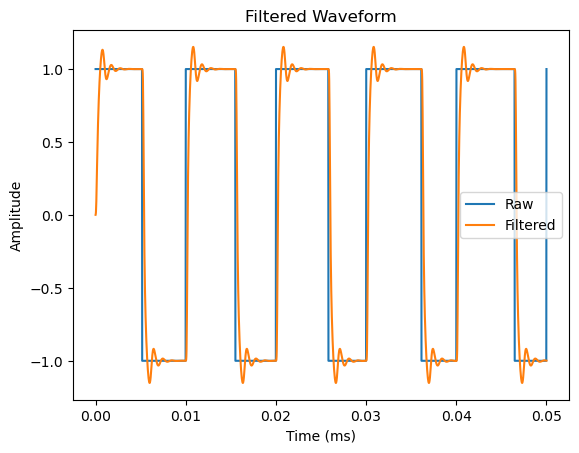

Maximum iterations: 4
CPU times: user 1.91 s, sys: 341 ms, total: 2.25 s
Wall time: 747 ms


In [3]:
%%time

# filter parameters
input_gain = 2.6
cutoff = 3000.0
r = 1.6 # resonance (0.0 to 4.0)

g = cutoff * np.pi / samplerate
boosted_wave = wave * input_gain

# initial values
y = np.array([0.0, 0.0, 0.0, 0.0])  # inital guess
errorThresh = 0.000001 # max NR error (stopping condition)
maxIter = 0
filtered_wave = np.zeros(len(boosted_wave))

# state values (initially zero)
s1 = 0.0
s2 = 0.0
s3 = 0.0
s4 = 0.0

# NR loop
for n in range(len(boosted_wave)):
    # input (current sample)
    x = boosted_wave[n]
    
    i = 0
    residue = 100 # something large
    while(abs(residue) > errorThresh and i < 50):

        # F(y) using current y values
        y1 = g*(np.tanh(x-r*y[3])-np.tanh(y[0])) + s1 - y[0]
        y2 = g*(np.tanh(y[0])-np.tanh(y[1])) + s2 - y[1]
        y3 = g*(np.tanh(y[1])-np.tanh(y[2])) + s3 - y[2]
        y4 = g*(np.tanh(y[2])-np.tanh(y[3])) + s4 - y[3]
        F = np.array([y1, y2, y3, y4]).T

        # Jacobian Matrix
        J = np.array([
            [(-g*(1.0-(np.tanh(y[0])**2))-1.0), 0.0, 0.0, (g*(1.0-(np.tanh(x-r*y[3])**2)))],
            [(g*(1.0-(np.tanh(y[0])**2))), (-g*(1.0-(np.tanh(y[1])**2))-1.0), 0.0, 0.0],
            [0.0, (g*(1.0-(np.tanh(y[1])**2))), (-g*(1.0-(np.tanh(y[2])**2))-1.0), 0.0],
            [0.0, 0.0, (g*(1.0-(np.tanh(y[2])**2))), (-g*(1.0-(np.tanh(y[3])**2))-1.0)]])

        # calculate next NR step
        y_est = y
        y = y - np.matmul(inv(J), F)
        residue = y[3] - y_est[3] # only care about y4 residue
        i = i + 1
    
    # save y
    filtered_wave[n] = y[3]
    
    # update states
    s1 = 2.0 * y[0] - s1
    s2 = 2.0 * y[1] - s2
    s3 = 2.0 * y[2] - s3
    s4 = 2.0 * y[3] - s4
    
    # log max iterations
    if i > maxIter:
        maxIter = i
    
# plot waveform 
plt.plot(time, wave, label="Raw")
plt.plot(time, filtered_wave, label="Filtered")
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")
plt.title("Filtered Waveform")
plt.legend()
plt.show()

# print max iterations
print("Maximum iterations: " + str(maxIter))

## Optimizations

1. Precalculate Tanh()
2. Replace matrix inversion with solver

Maximum iterations: 4
CPU times: user 641 ms, sys: 33.5 ms, total: 674 ms
Wall time: 579 ms


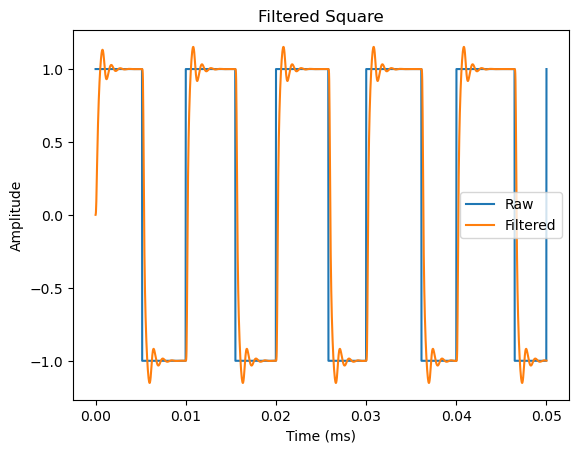

In [7]:
%%time

# filter parameters
input_gain = 2.6
cutoff = 3000.0
r = 1.6 # resonance (0.0 to 4.0)

g = cutoff * np.pi / samplerate
boosted_wave = wave * input_gain

# initial values
y = np.array([0.0, 0.0, 0.0, 0.0])  # inital guess
errorThresh = 0.000001 # max NR error (stopping condition)
maxIter = 0
filtered_wave = np.zeros(len(boosted_wave))

# state values (initially zero)
s1 = 0.0
s2 = 0.0
s3 = 0.0
s4 = 0.0

# NR loop
for n in range(len(boosted_wave)):
    # input (current sample)
    x = boosted_wave[n]
    
    i = 0
    residue = 100 # something large
    while(abs(residue) > errorThresh and i < 50):
        # pre-compute tanh functions
        tanh_x_ry4 = np.tanh(x-r*y[3])
        tanh_y1 = np.tanh(y[0])
        tanh_y2 = np.tanh(y[1])
        tanh_y3 = np.tanh(y[2])
        tanh_y4 = np.tanh(y[3])
        
        # F(y) using current y values
        y1 = g*(np.tanh(x-r*y[3])-np.tanh(y[0])) + s1 - y[0]
        y2 = g*(np.tanh(y[0])-np.tanh(y[1])) + s2 - y[1]
        y3 = g*(np.tanh(y[1])-np.tanh(y[2])) + s3 - y[2]
        y4 = g*(np.tanh(y[2])-np.tanh(y[3])) + s4 - y[3]
        F = np.array([y1, y2, y3, y4]).T

        # pre-compute re-used algebra (helper "functions")
        help_x_ry4 = 1.0 - (tanh_x_ry4 * tanh_x_ry4)
        help_y1 = 1.0 - (tanh_y1 * tanh_y1)
        help_y2 = 1.0 - (tanh_y2 * tanh_y2)
        help_y3 = 1.0 - (tanh_y3 * tanh_y3)
        help_y4 = 1.0 - (tanh_y4 * tanh_y4)
        
        # Jacobian Matrix        
        J = np.array([
            [(-g*help_y1 - 1.0), 0.0, 0.0, (g*help_x_ry4)],
            [(g*help_y1), (-g*help_y2-1.0), 0.0, 0.0],
            [0.0, (g*help_y2), (-g*help_y3 - 1.0), 0.0],
            [0.0, 0.0, (g*help_y3), (-g*help_y4-1.0)]])

        # calculate next NR step
        y_est = y
        #y = y - np.matmul(inv(J), F)
        delta_y = np.linalg.solve(J, -1*F) # linear solver replaces the matrix inversion equation above
        y = delta_y + y            
        residue = y[3] - y_est[3] # only care about y4 residue
        i = i + 1
    
    # save y
    filtered_wave[n] = y[3]
    
    # update states
    s1 = 2.0 * y[0] - s1
    s2 = 2.0 * y[1] - s2
    s3 = 2.0 * y[2] - s3
    s4 = 2.0 * y[3] - s4
    
    # log max iterations
    if i > maxIter:
        maxIter = i
    
# plot waveform 
plt.plot(time, wave, label="Raw")
plt.plot(time, filtered_wave, label="Filtered")
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")
plt.title("Filtered Waveform")
plt.legend()
plt.show()
#plt.savefig('square1.png')

# print max iterations
print("Maximum iterations: " + str(maxIter))